In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os
import sys

src_dir = './../../src/'
sys.path[0] = src_dir

import matplotlib.pyplot as plt

import glob

import numpy as np
import pandas as pd
import seaborn as sns

from collections import OrderedDict

from access_biology_data import meta, relations, properties
from access_literature_data import medline
from access_science_shared import standardizer 

In [4]:
sys.path.append('./../src/')
from aging_tools import inout, export
from access_aging_data import earlier_studies, chaperome, companions, sequencing

from access_science_shared import standardizer

In [6]:
from narrative import nar181026_heat_confidence_genes
# from narrative import nar181101_single_cell
from narrative import nar181205_networks

In [7]:
save_images = True

In [8]:
outfolder = '190406_transcript_length_tilting'

In [9]:
ref_genes = standardizer.reference_genes(10090, 'orp')

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [10]:
all_de, detection, mice_in_comparisons, triplicate_series = nar181026_heat_confidence_genes.load_detection(
    detection_column='padj')


tissues_to_consider = ['BAT', 'Blood', 'GutEP', 'MuscSat', 'Adrenal', 'Kidney',
       'Heart', 'Liver', 'Skin', 'Stomach', 'Brain', 'SI',
       'LI', 'Cerebellum', 'WAT', 'Esophagus', 'Lung'] 

all_de = all_de[
    (all_de['tissue'].isin(tissues_to_consider)) & 
    (all_de['pfu']==0) &
    (all_de['gene_ncbi'].isin(ref_genes))

]


In [11]:
from scipy.stats import spearmanr

In [12]:
from natsort import natsorted

In [13]:
conditions = natsorted(all_de['condition'].unique())

In [14]:
out = pd.DataFrame(index=conditions, columns=[
    'corr', 'pval'
]).rename_axis('condition')

In [15]:
pr = properties.genbank_validated_rna(10090)[['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']].rename(columns={
    'Genbank_validated_RNA: full_SumACGT': 'length'
})

pr.loc[:, 'log_length'] = np.log10(pr['length'])

In [16]:
%%time

for condition in conditions:
    d = all_de[
        (all_de['de_unit']=='both') & (all_de['condition']==condition)
    ]

    d = d[['gene_ncbi', 'o_over_y', 'log_padj', 'log_pvalue']].dropna()
    d = pd.merge(d, pr)

    r, p = spearmanr(d['log_length'], d['o_over_y'])
    d = d.set_index('gene_ncbi')

    out.loc[condition, 'corr'] = r
    out.loc[condition, 'pval'] = p
    out.loc[condition, 'genes'] = d.shape[0]

CPU times: user 3min 47s, sys: 2.98 s, total: 3min 50s
Wall time: 1min 59s


In [17]:
# out = out.dropna()

In [18]:
out = out.reset_index()

In [19]:
out = pd.merge(out, all_de[['condition', 'younger', 'older']].drop_duplicates())

In [20]:
mega = pd.merge(
    out,
    all_de[['condition', 'tissue', 'younger', 'older']].drop_duplicates()
)

In [21]:

if save_images:
    export.export_full_frame('{}/stats_on_imbalance.xlsx'.format(outfolder), mega, save_index=False)

In [22]:
out.head()

,condition,corr,pval,genes,younger,older
0,Adrenal_0_4_9,-0.0036287,0.729003,9118.0,4.0,9.0
1,Adrenal_0_4_12,-0.0832552,2.09174e-16,9709.0,4.0,12.0
2,Adrenal_0_4_18,0.0600566,1.6534e-09,10061.0,4.0,18.0
3,Adrenal_0_4_24,-0.162002,1.07144e-58,9814.0,4.0,24.0
4,Adrenal_0_9_12,-0.0681303,3.68542e-13,11352.0,9.0,12.0


In [23]:
u = out[out['younger']==4]

In [24]:
u['corr'] = u['corr'].astype(float)

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
u['older'] = u['older'].astype(float)

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
u = pd.merge(
    u,
    all_de[['condition', 'tissue']].drop_duplicates())

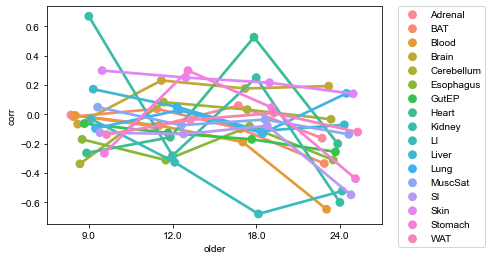

In [27]:
sns.pointplot(x='older', y='corr', hue='tissue', data=u, dodge=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
if save_images:
    export.export_image('{}/tissue_line_4months_to_older.pdf'.format(outfolder))

In [28]:
u[u['older']==24].sort_values('corr')

,condition,corr,pval,genes,younger,older,tissue
11,Blood_0_4_24,-0.646453,3.79871e-95,794.0,4.0,24.0,Blood
35,Kidney_0_4_24,-0.599801,0,8197.0,4.0,24.0,Kidney
55,SI_0_4_24,-0.548157,0,6036.0,4.0,24.0,SI
39,LI_0_4_24,-0.522198,0,9807.0,4.0,24.0,LI
63,Stomach_0_4_24,-0.438255,2.5601e-268,5745.0,4.0,24.0,Stomach
7,BAT_0_4_24,-0.334887,1.30268e-218,8376.0,4.0,24.0,BAT
23,Esophagus_0_4_24,-0.310671,1.92384e-151,6772.0,4.0,24.0,Esophagus
27,GutEP_0_4_24,-0.254853,6.09979e-122,8214.0,4.0,24.0,GutEP
31,Heart_0_4_24,-0.199111,4.54656e-101,11263.0,4.0,24.0,Heart
3,Adrenal_0_4_24,-0.162002,1.07144e-58,9814.0,4.0,24.0,Adrenal


In [29]:
from scipy.stats import mannwhitneyu

In [30]:
mannwhitneyu(
    u[u['older']==18]['corr'],
    u[u['older']==24]['corr'],
)

MannwhitneyuResult(statistic=76.0, pvalue=0.009586242377611544)

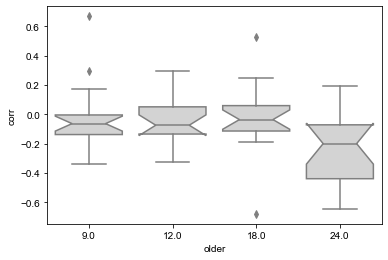

In [31]:
sns.boxplot(x='older', y='corr', data=u, notch=True, color='lightgrey')

if save_images:
    export.export_image('{}/box_4months_to_older.pdf'.format(outfolder))

In [32]:
u = out.copy()

In [33]:
u['older'] = u['older'].astype(float)
u['corr'] = u['corr'].astype(float)

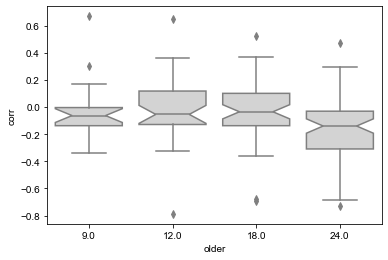

In [34]:
sns.boxplot(x='older', y='corr', data=u, notch=True, color='lightgrey')
if save_images:
    export.export_image('{}/box_any_age_to_older.pdf'.format(outfolder))

In [35]:
u[(u['younger']==4) & (u['older']==18)].sort_values('corr')

,condition,corr,pval,genes,younger,older
92,LI_0_4_18,-0.678338,0,8603.0,4.0,18.0
22,Blood_0_4_18,-0.188596,1.49011e-74,9217.0,4.0,18.0
62,GutEP_0_4_18,-0.169653,8.05382e-68,10371.0,4.0,18.0
112,Lung_0_4_18,-0.127924,1.85842e-39,10472.0,4.0,18.0
102,Liver_0_4_18,-0.113116,2.01273e-31,10562.0,4.0,18.0
12,BAT_0_4_18,-0.098445,6.38218e-19,8109.0,4.0,18.0
52,Esophagus_0_4_18,-0.081018,1.61055e-12,7581.0,4.0,18.0
132,SI_0_4_18,-0.077829,1.47054e-15,10482.0,4.0,18.0
122,MuscSat_0_4_18,-0.035185,0.000333899,10392.0,4.0,18.0
162,WAT_0_4_18,0.010001,0.305164,10514.0,4.0,18.0


In [36]:
u[(u['younger']==4) & (u['older']==24)].sort_values('corr')

,condition,corr,pval,genes,younger,older
23,Blood_0_4_24,-0.646453,3.79871e-95,794.0,4.0,24.0
83,Kidney_0_4_24,-0.599801,0,8197.0,4.0,24.0
133,SI_0_4_24,-0.548157,0,6036.0,4.0,24.0
93,LI_0_4_24,-0.522198,0,9807.0,4.0,24.0
153,Stomach_0_4_24,-0.438255,2.5601e-268,5745.0,4.0,24.0
13,BAT_0_4_24,-0.334887,1.30268e-218,8376.0,4.0,24.0
53,Esophagus_0_4_24,-0.310671,1.92384e-151,6772.0,4.0,24.0
63,GutEP_0_4_24,-0.254853,6.09979e-122,8214.0,4.0,24.0
73,Heart_0_4_24,-0.199111,4.54656e-101,11263.0,4.0,24.0
3,Adrenal_0_4_24,-0.162002,1.07144e-58,9814.0,4.0,24.0


In [37]:
mannwhitneyu(
    u[(u['younger']==4) & (u['older']==18)]['corr'],
    u[(u['younger']==4) & (u['older']==24)]['corr'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=213.0, pvalue=0.01917248475522309)

In [38]:
mannwhitneyu(
    u[(u['younger']==4) & (u['older']==9)]['corr'],
    u[(u['younger']==4) & (u['older']==24)]['corr'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=207.0, pvalue=0.03272027315980588)

In [39]:
mannwhitneyu(
    u[(u['younger']==4) & (u['older']==12)]['corr'],
    u[(u['younger']==4) & (u['older']==24)]['corr'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=207.0, pvalue=0.03272027315980588)

In [40]:
mannwhitneyu(
    u[(u['younger']==4) & (u['older']==9)]['corr'],
    u[(u['younger']==4) & (u['older']==18)]['corr'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=128.0, pvalue=0.5815675165100369)